In [40]:
import os
import numpy as np
import math
from scipy.stats import norm
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda,int64, float32, float64,int16,int32
from matplotlib import pyplot as plt

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [37]:
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vec_exp (x):
    return np.exp(x)

def vec_log (x):
    return np.log(x)

A = np.array([2, 5, 10, 3, 8]).astype(np.float32) 

print("log(A) : ", vec_log(A))
print("exp(A) : ", vec_exp(A))

log(A) :  [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
exp(A) :  [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

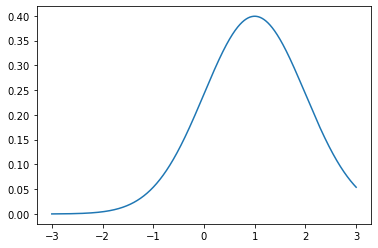

In [13]:
x= np.linspace(-3,3,100000)

values = norm.pdf(x, loc=1, scale=1)
plt.plot(x,values)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$threshold = 15$

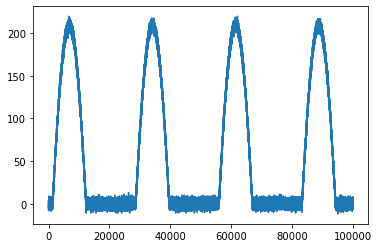

<ipython-input-47-44b62a1b8401>:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "zerosup" failed type inference due to: Unknown attribute 'copy' of type int16

File "<ipython-input-47-44b62a1b8401>", line 16:
def zerosup(datas,threshold) : 
    dt =datas.copy()
    ^

[1] During: typing of get attribute at <ipython-input-47-44b62a1b8401> (16)

File "<ipython-input-47-44b62a1b8401>", line 16:
def zerosup(datas,threshold) : 
    dt =datas.copy()
    ^

  @jit(int32(int16,int16))
C:\Users\ophel\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Function "zerosup" was compiled in object mode without forceobj=True.

File "<ipython-input-47-44b62a1b8401>", line 15:
@jit(int32(int16,int16))
def zerosup(datas,threshold) : 
^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\ophel\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compil

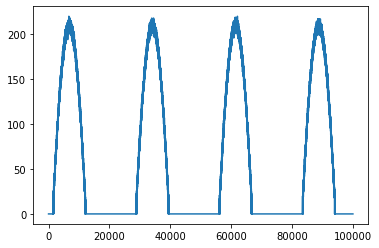

In [47]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)


#put your code here
plt.plot(data)
plt.show()

@jit(int32(int16,int16))
def zerosup(datas,threshold) : 
    dt =datas.copy()
    dt[dt<threshold]=0
    return dt
    
newdata = zerosup(data,15)
plt.plot(newdata)  
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [52]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@cuda.jit
def double_kernel(io_array,io_array2,a,c):
    row, col = cuda.grid(2)
    if row < io_array.shape[0] and col < io_array.shape[1]:
        io_array[row][col] = np.tanh(a*np.transpose(io_array[row][col])*io_array2[row][col]+c) # do the computation
        
        
# Configure the blocks
threadsperblock = (3, 3) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(X.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Now start the kernel
double_kernel[blockspergrid, threadsperblock](X,Y,1,1)

# Print the result
print("k = ",X)

k =  [[0.76839162 0.83163777 0.86538065]
 [0.82393118 0.80632448 0.80138274]
 [0.78789824 0.94726867 0.80506558]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [58]:
# CUDA kernel
@cuda.jit
def double_kernel_2D(io_array):
    row, col, deep = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and  deep < io_array.shape[2]:
        io_array[row][col][deep] = np.cos(io_array[row][col][deep]) # do the computation

# Host code   
data = np.random.randn(256,256,256)

# Configure the blocks
threadsperblock = (128, 64,16) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y,blockspergrid_z)

double_kernel_2D[blockspergrid, threadsperblock](data)
print(data)

MemoryError: Unable to allocate 128. MiB for an array with shape (256, 256, 256) and data type float64

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [59]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.array([np.random.randint(1,100) for i in range (0,24*12)]).reshape(24,12)
B = np.array([np.random.randint(1,100) for i in range (0,22*12)]).reshape(12,22)
C = np.random.rand(24,22)

# Configure the blocks
threadsperblock = (12, 11)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

RuntimeError: can't start new thread